In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from livelossplot import PlotLossesKeras
import lmfit

TARGET = 'fc'

print(tf.__version__)
np.set_printoptions(precision=3, suppress=True)

2.11.0


In [33]:
df = pd.read_csv('orpv3.csv').dropna()
print(df)

           orp        ph   ppm
0   580.909091  8.500000   0.2
1   600.000000  8.400000   0.2
2   650.000000  8.109091   0.2
3   665.000000  8.000000   0.2
4   700.000000  7.700000   0.2
..         ...       ...   ...
75  810.000000  8.000000  10.0
76  846.000000  7.500000  10.0
77  850.000000  7.450000  10.0
78  871.000000  7.000000  10.0
79  895.000000  6.500000  10.0

[64 rows x 3 columns]


In [62]:
ppms = df['ppm'].unique()
models = {}
for ppm in ppms:    
    data =df.loc[df['ppm'] == ppm]
    xdata = data['orp'].to_numpy()
    ydata = data['ph'].to_numpy()
    lmodel = lmfit.models.PolynomialModel(degree=2)
    params = lmodel.guess(ydata, x=xdata)
    fit = lmodel.fit(ydata, params, x=xdata)    
    models[ppm] = fit
    #print(fit.fit_report())
    #plt.figure() 
    #fit.plot_fit(title=str(ph))
models.keys()

dict_keys([0.2, 0.6, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0])

In [70]:
vs = []
for fc, fit in models.items():
    for orp in range(200, 1000, 10):
        ph = fit.eval(x=orp)        
        vs.append((orp, ph, fc))
dataset = pd.DataFrame(vs, columns= ('orp', 'ph', 'fc'))
dataset.describe()

,orp,ph,fc
count,640.000000,640.000000,640.000000
mean,595.000000,6.026519,3.600000
std,231.102684,3.072686,3.256773
min,200.000000,-9.010663,0.200000
25%,397.500000,4.899513,0.900000
50%,595.000000,7.026488,2.500000
75%,792.500000,8.231279,5.500000
max,990.000000,8.658838,10.000000


           mean         std
orp  594.472656  231.389310
ph     6.015783    3.105108
fc     3.647266    3.240575


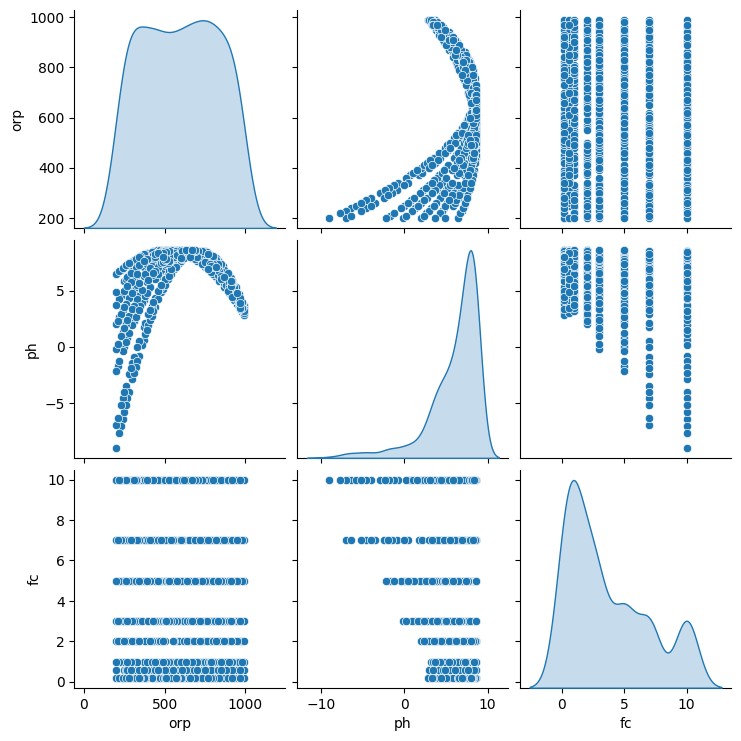

In [76]:
train_dataset = dataset.sample(frac=0.8)#, random_state=0)
test_dataset = dataset.drop(train_dataset.index) #dataset_orig # dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
train_labels = train_features.pop(TARGET)

test_features = test_dataset.copy()
test_labels = test_features.pop(TARGET)

print(train_dataset.describe().transpose()[['mean', 'std']])
sns.pairplot(train_dataset, diag_kind='kde')

inorm = tf.keras.layers.Normalization(axis=-1, input_shape=[2, ])
inorm.adapt(np.array(train_features))
onorm = tf.keras.layers.Normalization(axis=-1, invert=True)
onorm.adapt(train_labels)

In [86]:
checkpoint_filepath = 'checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

def build_and_compile_model(inorm, onorm):
  model = keras.Sequential([
      inorm,
      layers.Dense(4, activation='elu'),
      layers.Dense(2, activation='elu'),
      layers.Dense(1), 
      onorm,
  ])
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model
model = build_and_compile_model(inorm, onorm)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_12 (Normaliza  (None, 2)                5         
 tion)                                                           
                                                                 
 dense_32 (Dense)            (None, 4)                 12        
                                                                 
 dense_33 (Dense)            (None, 2)                 10        
                                                                 
 dense_34 (Dense)            (None, 1)                 3         
                                                                 
 normalization_13 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
Total params: 33
Trainable params: 25
Non-trainable p

KeyboardInterrupt: 

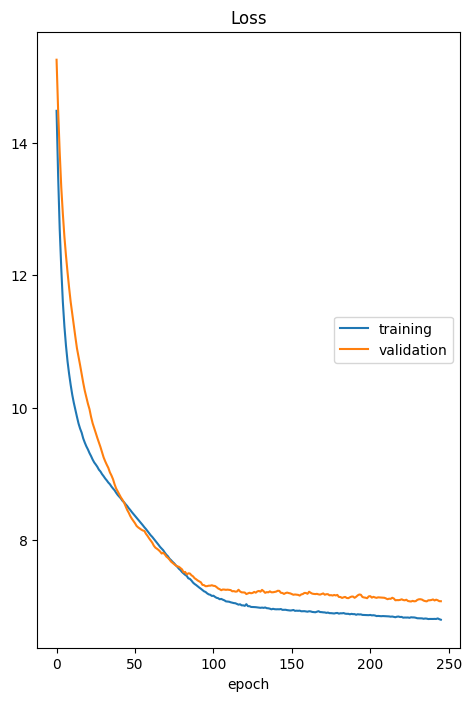

In [87]:
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.3,
    verbose=1, epochs=100, callbacks=[PlotLossesKeras(), model_checkpoint_callback])
print('mse:', model.evaluate(test_features, test_labels, verbose=0))

<Axes: xlabel='fc'>

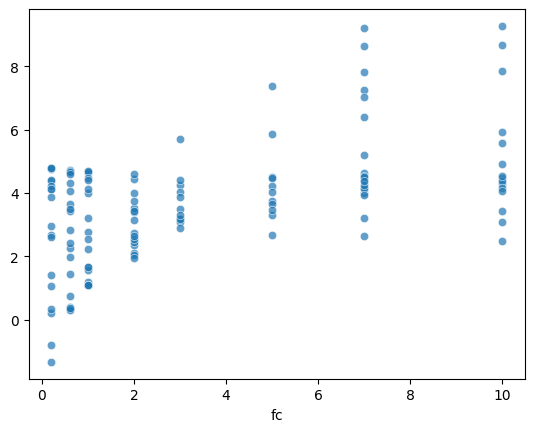

In [88]:
fmodel = checkpoint_filepath
#fmodel = 'model_fc.h5'

model = keras.models.load_model(fmodel, compile=False)
model.layers[-1].invert = True #Bug in Keras https://github.com/keras-team/keras/issues/17556


y = model.predict(test_features, verbose=0)
y = pd.DataFrame(y)[0]
sns.scatterplot(x=test_labels, y=y.to_numpy(), alpha=0.7)

In [41]:
model.save(f'model_{TARGET}.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(f'model_{TARGET}.tflite', "wb") as f:
  f.write(tflite_model)
print('done')

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp59rn3hc9\assets
done


In [89]:
p0 = 629
p1 = 7.76
print(p0, p1)
v = model.predict([(p0, p1)], verbose=0)[0][0]
print('output: ', v)

629 7.76
output:  4.455237


In [98]:
ppm = 1
x =df.loc[df['ppm'] == ppm]
x['pred'] = model.predict(x[['orp', 'ph']].to_numpy(), verbose=0)
x.plot(x=ppm, y=["ppm", "pred"]);

AttributeError: 'DataFrame' object has no attribute 'toumpy'

    8.2   ph      pred  rasp
0   487  8.5  0.037617   0.2
1   529  8.5  0.157362   0.3
2   559  8.5  0.288819   0.4
3   583  8.5  0.431090   0.5
4   602  8.5  0.573518   0.6
5   610  8.5  0.642891   0.6
6   618  8.5  0.718588   0.7
7   625  8.5  0.790482   0.7
8   632  8.5  0.867201   0.8
9   638  8.5  0.936116   0.9
10  644  8.5  1.008144   0.9
11  650  8.5  1.083487   1.0
12  655  8.5  1.148966   1.1
13  665  8.5  1.287837   1.3
14  674  8.5  1.422653   1.6
15  682  8.5  1.551107   2.0
16  690  8.5  1.688590   2.5
17  697  8.5  1.817218   3.2
18  710  8.5  2.079036   5.4
19  716  8.5  2.210969   7.1
20  727  8.5  2.473249  12.0
21  737  8.5  2.737148  20.0
22  751  8.5  3.152890  42.3


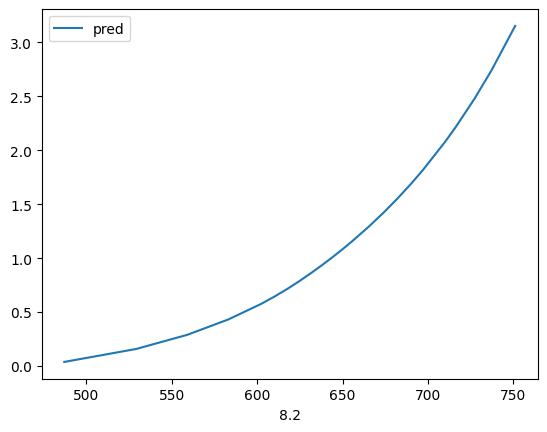

In [44]:
ph = 8.5
ph_last  = 8.2

x = df[[str(ph_last)]]
x = x.assign(ph=ph)
x['pred'] =  model.predict(x[[str(ph_last), 'ph']], verbose=0)
x['rasp'] =  rasppool_predict(x[[str(ph_last), 'ph']])

print(x)
x.plot(x=str(ph_last), y=["pred"]);